<a href="https://colab.research.google.com/github/LFBBMRML/Colab_GAN/blob/Colab_Code/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf

tf.__version__

import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import os
import time
import glob
import imageio
import PIL
from IPython import display
import cProfile
import datetime

170500096/170498071 [==============================] - 2s 0us/step


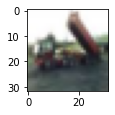

In [ ]:
(train_images, train_labels), (test_images,test_labels) = tf.keras.datasets.cifar10.load_data() 

#print(train_labels[:10])
plt.figure(figsize=(1.5,1.5))
plt.imshow((train_images[2]).astype('uint8'))
plt.grid(False)
plt.show()

train_images = train_images.reshape(train_images.shape[0], 32, 32, 3).astype('float32') #4. Wert ist Dimension für Bildkanal. 1 steht für Grauwertbild. Für Farbbild müsste 3 gesetzt werden, für drei Dimensionen (Rot, Blau, Grün)
train_images = (train_images/255) #- 127.5) / 127.5 normalization [-1,1]. Möglichkeit2: train_images/255 [0,1]

#my_dpi=90

#print(train_images[5])
#print(train_labels[5])
#print(test_images.shape)
#print(test_labels.shape)

In [ ]:
BUFFER_SIZE = train_images.shape[0] #Puffergröße MNIST: 60000, CIFAR: 50000
BATCH_SIZE = 256 #Stapelgröße

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
def generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(8*8*256, input_shape=(100, )))   #(8*8*256, use_bias=False, input_shape=(100, )))
  model.add(layers.BatchNormalization(momentum=0.9))      #Default: training=False 
  model.add(layers.LeakyReLU(alpha=0.1))

  model.add(layers.Reshape((8, 8, 256)))
  assert model.output_shape == (None, 8, 8, 256)          #wenn Output_Shape dem gewollten entspricht (also None, 7, 7, 256) läuft das Programm weiter. Ansonsten gibt es einfach einen AsserttionError.
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1,1), padding = 'same'))
  assert model.output_shape == (None, 8, 8, 128)          #Note: None is the batch size
  model.add(layers.BatchNormalization(momentum=0.9))
  model.add(layers.LeakyReLU(alpha=0.1))
  

  model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding = 'same'))
  assert model.output_shape == (None, 16, 16, 64)
  model.add(layers.BatchNormalization(momentum=0.9))
  model.add(layers.LeakyReLU(alpha=0.1))
  
  model.add(layers.Conv2DTranspose(32, (5,5), strides=(2,2), padding = 'same'))
  assert model.output_shape == (None, 32, 32, 32)
  model.add(layers.BatchNormalization(momentum=0.9))
  model.add(layers.LeakyReLU(alpha=0.1))

  model.add(layers.Conv2DTranspose(3, (5,5), strides=(1,1), padding='same'))
  assert model.output_shape == (None, 32, 32, 3)
  model.add(layers.Activation('sigmoid'))

  #model.summary()
  return model

In [ ]:
# generator_model() Der Aufruf ist glaub ich eher sinnfrei

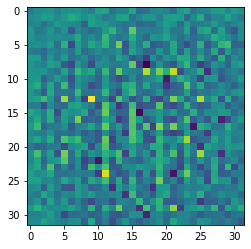

In [ ]:
generator = generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0]*255) #Doku zu imshow https://matplotlib.org/3.3.2/api/_as_gen/matplotlib.pyplot.imshow.html. Hilfreich wenn anstatt einem Kanal drei Kanäle benötigt werden.

In [ ]:
def discriminator_model():
  model = tf.keras.Sequential()

  model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
  model.add(layers.LeakyReLU(alpha=0.1)) #parameterübergabe: alpha=0.2
  model.add(layers.Dropout(0.4))
  
  model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.1))
  model.add(layers.Dropout(0.4))

  model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.1))
  model.add(layers.Dropout(0.4))

  model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.1))
  model.add(layers.Dropout(0.4))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))
  model.add(layers.Activation('sigmoid'))

  #model.summary()
  return model

In [ ]:
discriminator = discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.4985654]], shape=(1, 1), dtype=float32)


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def dis_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [ ]:
def gen_loss(fake_output):
  loss = cross_entropy(tf.ones_like(fake_output), fake_output)
  return loss

In [ ]:
dis_opt = tf.keras.optimizers.Adam(1e-7)
gen_opt = tf.keras.optimizers.Adam(1e-7)

In [ ]:
EPOCHS = 2
noise_dim = 100
num_examples_to_generate = 4
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
loss_history = []
@tf.function #fungiert als '.compile'
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim], 0.5, 0.5)

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_image = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_image, training=True)

    g_loss = gen_loss(fake_output)
    d_loss = dis_loss(real_output, fake_output)

    loss_history.append(g_loss)

  gradient_of_gen = gen_tape.gradient(g_loss, generator.trainable_variables)
  gradient_of_dis = disc_tape.gradient(d_loss, discriminator.trainable_variables)

  gen_opt.apply_gradients(zip(gradient_of_gen, generator.trainable_variables))
  dis_opt.apply_gradients(zip(gradient_of_dis, discriminator.trainable_variables))


In [ ]:
#def diagramm_loss_D(abschnitt, verlust):
  #x = abschnitt
  #y = verlust
  #plt.plot(x, y, 'g')
  #plt.title('Discriminator')
  #plt.xlabel('Epoche')
  #plt.ylabel('Loss')
  #plt.show()


#def diagramm_loss_G(abschnitt, verlust):  #abschnitt = epoche, verlust = loss
  #x = abschnitt
  #y = verlust
  #plt.plot(x, y, 'r')
  #plt.title('Generator')
  #plt.xlabel('Epoche')
  #plt.ylabel('Loss')
  #plt.show()

In [ ]:
def train(dataset, epochs):
  epoche_history = []
  ges_time = []
  for epoch in range(epochs):
    
    start = time.time()
    
    for image_batch in dataset:
      train_step(image_batch)

    epoche_history.append('Epoche: {} Zeit {} '.format(epoch+1, time.time()-start))
    ges_time.append(time.time()-start)
 
  display.clear_output(wait=True) 
  generate_and_save_image(generator, epochs, seed)

  for i in epoche_history:
    print(i)
  
  print("Die gesamte Dauer beträgt: " + str(sum(ges_time)) + " für " + str(EPOCHS) + " Epochen ")

In [ ]:
def generate_and_save_image(model, epoch, test_input):
  predictions = model(test_input, training=False)
  
  fig = plt.figure(figsize=(3,3))
  for i in range(predictions.shape[0]):
    plt.subplot(2,2, i+1)
    plt.imshow(predictions[i, :, :, 0] * 255)
    plt.axis('off')

  plt.show()

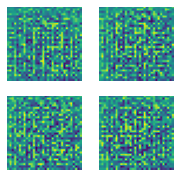

Epoche: 1 Zeit 38.79317545890808 
Epoche: 2 Zeit 38.09515571594238 
Die gesamte Dauer beträgt: 76.8883535861969 für 2 Epochen 


In [ ]:
train(train_dataset, EPOCHS)